In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pymc3 as pm
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (10,4)})

# Simulate neurons and voxels

Here's the game plan. Within our fake ROI of 50 voxels (each voxel will contain 100 neurons), we will have 6 runs of 42 trials each. Trial condition will alternate every trial, for a total of 252 trials with 126 trials per condition. In one condition, neuron spiking will be of greater amplitude. 

In [3]:
# Simulation parameters:
ntrials = 252
nvoxels = 50
nneurons = 100
vox_sd_mu = 20 
vox_sd_sd = 10 
nruns = 6
gain_diff = 0
noise = 1.5

# IEM parameters:
nchannels = 9
chan_shift = np.zeros(nchannels)
channel_sd = np.ones(nchannels)*30

In [4]:
# convenience functions to convert between the von Mises concentration and standard deviation
# this way we can always use standard deviation when dealiing with neural or voxel bandwidths

k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def within360(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

In [5]:
# cosd is a helper function that allows us to work with degrees (0-359) instead of radians
cosd = lambda x : np.cos( np.deg2rad(x/2) )

# make_vox: create voxel tuning function, following a von Mises distribution
make_vox = lambda xx, mu, sd : np.exp( sd2k(np.deg2rad(sd) ) * (cosd(xx-mu)-1) )

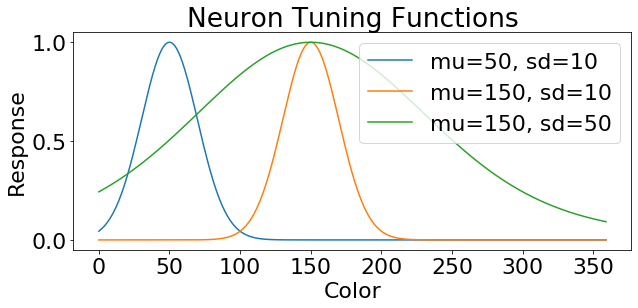

In [6]:
# demo of make_vox: 3 example neurons with different tuning functions
plt.plot(make_vox(np.linspace(0,359,360),50,10),label="mu=50, sd=10")
plt.plot(make_vox(np.linspace(0,359,360),150,10),label="mu=150, sd=10")
plt.plot(make_vox(np.linspace(0,359,360),150,50),label="mu=150, sd=50")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend()
plt.title("Neuron Tuning Functions")
plt.show()

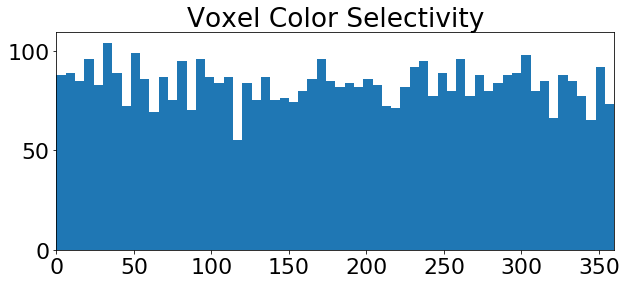

In [69]:
basis_points = np.linspace(0,360 - 360/nchannels,nchannels)

for chan in np.arange(len(basis_points)):
    basis_points[chan] = basis_points[chan] + chan_shift[chan]
basis_points = list(map(int, basis_points))

feature_space = np.linspace(0,359,360)

trial_features = list(map(int,np.random.choice(feature_space, ntrials)))

trial_runs = np.repeat(np.arange(nruns),ntrials//nruns)
trial_conds = np.tile(np.array([0,1]),ntrials//2)

vox_by_neuron_mu = np.random.rand(nvoxels,nneurons) * 360

plt.title('Voxel Color Selectivity')
plt.hist(vox_by_neuron_mu.flatten(),bins=60)
plt.xlim(xmin=0, xmax = 360)
plt.show()

y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels,nneurons))

trial_by_vox = np.full([ntrials,nvoxels], np.nan)

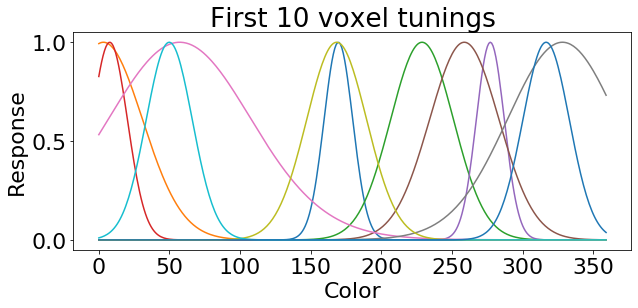

In [70]:
for vox in np.arange(nvoxels):
    vox_tuning = make_vox( 
        np.reshape(np.repeat(np.linspace(0,359,360),nneurons),[360,nneurons]),
        vox_by_neuron_mu[vox,:],
        vox_by_neuron_sd[vox,:])

    if vox <= 10:
        plt.plot(np.linspace(0,359,360),vox_tuning[:,vox])
        plt.xlabel('Color')
        plt.ylabel('Response')
        plt.title('First 10 voxel tunings')

    for trial in np.arange(ntrials):
        neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*noise)
        neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*gain_diff + 1)
        trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
        

# Inverted Encoding Model

## Create Forward Model & Design Matrix

In [71]:
trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features

tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features

trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

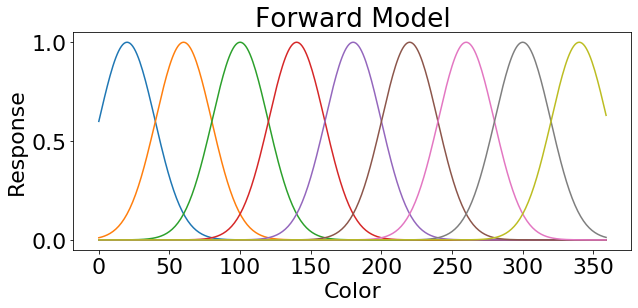

In [72]:
make_cos_basis_sd = lambda xx, mu, sd : np.exp( sd2k(np.deg2rad(sd) ) * (cosd(xx-mu) )) ** ( nchannels - (nchannels % 2) )
make_cos_basis = lambda xx, mu : cosd(xx-mu) ** ( nchannels - (nchannels % 2) )

basis_set = np.full( (360 , nchannels) , np.nan)
    
# create each basis channel
for chan in np.arange(nchannels):
    basis_set[:,chan] = make_cos_basis_sd( feature_space, basis_points[chan], channel_sd[chan] )
        
# normalize channels
scaler = MinMaxScaler()
for chan in np.arange(nchannels):
    scaler.fit(basis_set[:,chan].reshape(-1, 1))
    basis_set[:,chan] = scaler.transform(basis_set[:,chan].reshape(-1, 1)).flatten()
        
# plot basis functions
for chan in np.arange(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Forward Model")
plt.show()


In [73]:
# show how forward model changes with different bandwidths:
# with plt.rc_context({'font.size': 10, 'figure.figsize': (5,2)}):
#     for bd in np.linspace(0,90,5):
#         print(bd)
#         for chan in np.arange(nchannels):
#             if bd == 0: # make_cos_basis_sd fails if bd < 10; need exception for stick function
#                 basis_set[:,chan] = np.zeros(360)
#                 basis_set[int(basis_points[chan]),chan] = 1
#             else: 
#                 basis_set[:,chan] = make_cos_basis_sd( feature_space, basis_points[chan], bd )
#             plt.plot(basis_set[:,chan])
#         plt.show()

In [74]:
# Original code created stimulus mask and then calculated trial weights like so, which I think is overly complicated and 
# can be boiled down into a single line of code in the cell below ...

# stim_mask = np.zeros( (ntrials,nchannels) )
# for trial in np.arange(ntrials):
#     stim_mask[trial,int(trial_features[trial]/(360/nchannels))]=1
    
# # stim_mask: what basis function corresponds to the ground truth for every trial?

# trial_weights = basis_set[basis_points,:] @ stim_mask.T

# # trial_weights: what activation of each basis function look like for every trial based on stim_mask?

# fig, (ax1, ax2) = plt.subplots(1, 2)

# ax1.imshow(stim_mask[:18,:])
# ax1.set(xlabel='Channel', ylabel='Trial ...');

# for trial in np.arange(ntrials):
#     ax2.plot(trial_weights[:,trial])

# ax2.set(xlabel='Channel', ylabel='Weight');

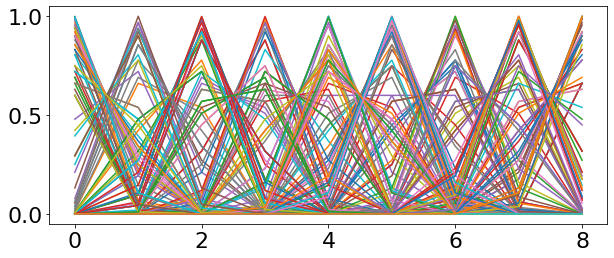

In [75]:
trial_weights = basis_set[trial_features,:].T

for trial in np.arange(ntrials):
    plt.plot(trial_weights[:,trial])

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [76]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 9


## Compute weights of forward model

In [77]:
channelweights_per_vox = np.linalg.lstsq(trial_weights[:,trn_or_tst==0].T , trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

In [78]:
# # visualization of results so far...
# with plt.rc_context({'font.size': 13}):
#     fig, (ax1, ax2, ax3) = plt.subplots(3, 1);
#     plt.subplots_adjust(hspace = 1.6)
    
#     vox_idx = int(np.where(channelweights_per_vox[0,:] == np.min(channelweights_per_vox[0,:]))[0])

#     ax1.plot(channelweights_per_vox[1:,:].T,linewidth=.5);
#     ax1.plot(channelweights_per_vox[0,:],linewidth=4,color='black');
#     ax1.axvline(x=vox_idx,linewidth=2,color='red');
#     ax1.set(title='Channel 1: Weight across voxels');

#     ax2.plot(np.mean(trn[trnf==0,:],axis=0),'o',label='Trials where stim was center of channel 1');
#     ax2.plot(np.mean(trn[trnf!=0,:],axis=0),'o',label='Trials where stim wasn''t center of channel 1');
#     ax2.axvline(x=vox_idx,linewidth=2,color='red');
#     ax2.legend(bbox_to_anchor=(1, 1.05))
#     ax2.set(title='Mean voxel activation (training trial)');
    
#     ax3.plot(np.mean(tst[tstf==0,:],axis=0),'o');
#     ax3.plot(np.mean(tst[tstf!=0,:],axis=0),'o');
#     ax3.axvline(x=vox_idx,linewidth=2,color='red');
#     ax3.set(title='Mean voxel activation (test trials)',xlabel='Voxel #');

## Invert to compute channel responses

### Reconstruct training data (note: this is circular, it should be near-perfect!)

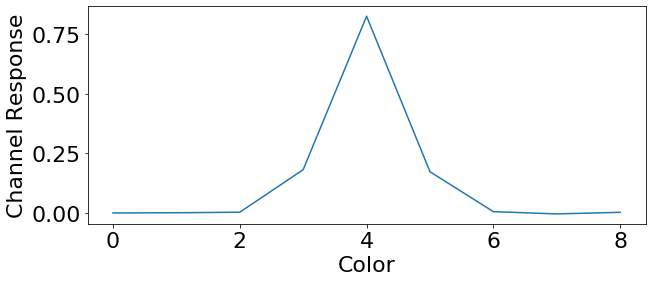

In [79]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T

cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
for ii in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin(np.abs( np.array(trnf[ii]) - basis_points ))
    cr_center_trn[ii,:] = np.roll( cr_trn[ii,:], shiftby - closest_basis );
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

### Assess training reconstruction fit

MAE: 10.571428571428571


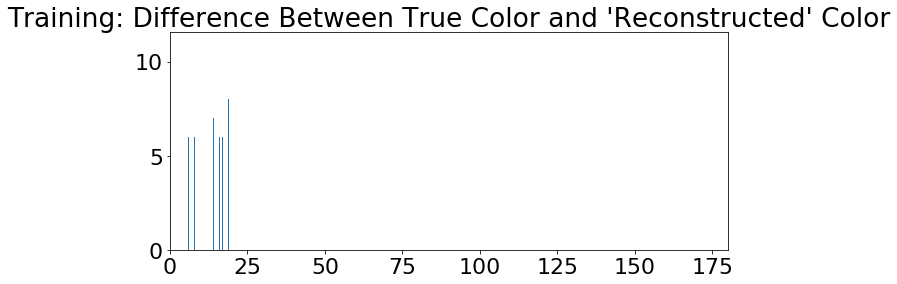

In [81]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_trn.shape[0],np.nan)

for trial in np.arange(cr_trn.shape[0]):
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.hist(within180(estimated_color - trnf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Training: Difference Between True Color and 'Reconstructed' Color")

trn_mae = mean_absolute_error(trnf, estimated_color)
print("MAE: {}".format(trn_mae))

### Reconstruct test data

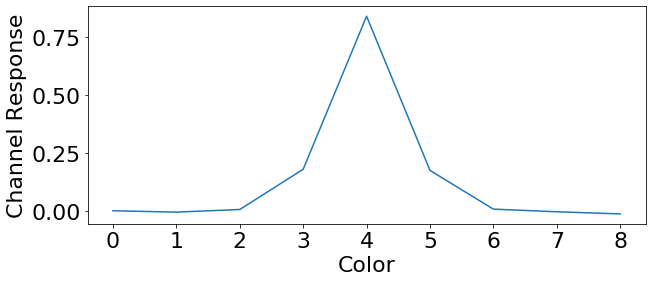

In [82]:
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
for ii in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin(np.abs( tstf[ii] - basis_points ))
    cr_center_tst[ii,:] = np.roll( cr_tst[ii,:], shiftby - closest_basis );
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.xticks(np.arange(nchannels))
plt.show()

### Assess test reconstruction fit

MAE: 10.055555555555555


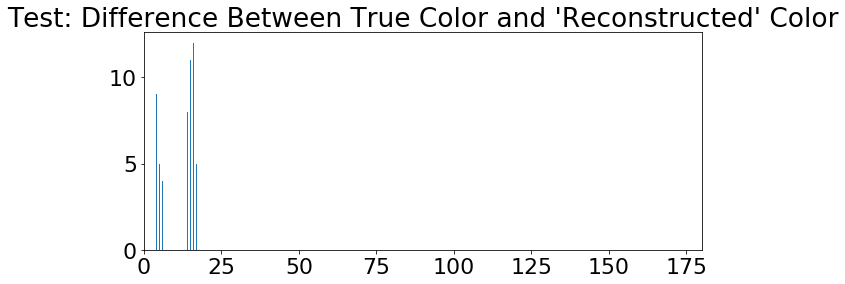

In [83]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)

for trial in np.arange(cr_tst.shape[0]):
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.hist(within180(estimated_color - tstf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and 'Reconstructed' Color")

tst_mae = mean_absolute_error(tstf, estimated_color)
print("MAE: {}".format(tst_mae))

### Null Distribution / Significance Test

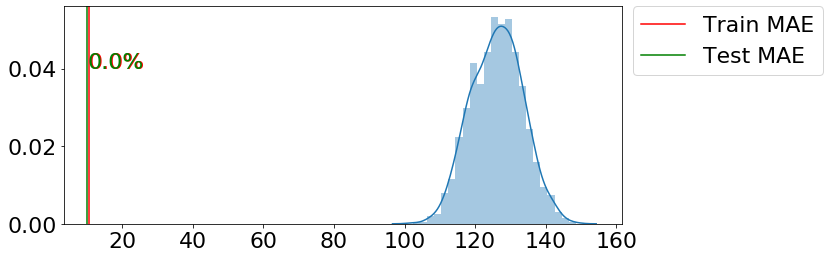

In [84]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

for perm in np.arange(1000):
    shuffled_tst, shuffled_tstf = unison_shuffled_copies(tst,tstf)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]

    null_mae[perm] = mean_absolute_error(shuffled_tstf, estimated_color)

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100
    
sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.04,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.show()

## Compare reconstructions across conditions

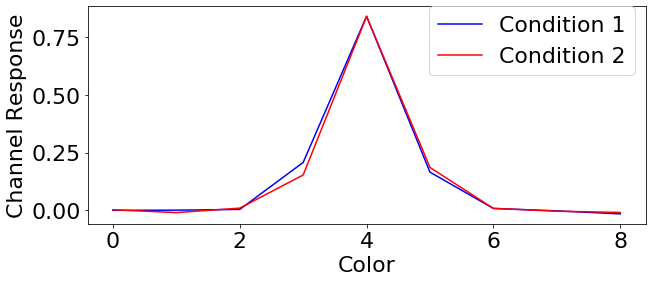

In [85]:
plt.plot(np.mean(cr_center_tst[trial_conds[ntrials//2:]==0],axis=0),color='blue',label="Condition 1")
plt.plot(np.mean(cr_center_tst[trial_conds[ntrials//2:]==1],axis=0),color='red',label="Condition 2")
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

# Function to automate IEM

In [88]:
def auto_recon(chan_shift,channel_sd):   
    basis_points = list(map(int, np.linspace(0,360 - 360/nchannels,nchannels)))
    for chan in np.arange(nchannels):
        basis_points[chan] = basis_points[chan] + chan_shift[chan]
    basis_points = list(map(int, basis_points))

    trn = trial_by_vox[:ntrials//2,:]
    trnf = trial_features[:ntrials//2]

    tst = trial_by_vox[ntrials//2:,:]
    tstf = trial_features[ntrials//2:]

    trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

    basis_set = np.full( (360 , nchannels) , np.nan)

    # create each basis channel
    for chan in np.arange(nchannels):
        basis_set[:,chan] = make_cos_basis_sd( feature_space, basis_points[chan], channel_sd[chan] )

    # normalize channels
    scaler = MinMaxScaler()
    for chan in np.arange(nchannels):
        scaler.fit(basis_set[:,chan].reshape(-1, 1))
        basis_set[:,chan] = scaler.transform(basis_set[:,chan].reshape(-1, 1)).flatten()
    
    # plot basis_set
    if sims == 0:
        for chan in np.arange(nchannels):
            plt.plot(basis_set[:,chan])
        plt.title('Basis Set for Condition {}'.format(cond))
        plt.show()
        
    trial_weights = basis_set[trial_features,:].T
    
    if np.linalg.matrix_rank(trial_weights) != nchannels:
        raise Exception('sim: {}, rank: {}, trial_weights is not full rank'.format(sims,np.linalg.matrix_rank(trial_weights)))
    
    channelweights_per_vox = np.linalg.lstsq(trial_weights[:,trn_or_tst==0].T , trn, rcond=None)[0] 
    # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank
    
    cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T
    
    estimated_color = np.full(cr_tst.shape[0],np.nan)
    for trial in np.arange(cr_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
        
    tst_mae = mean_absolute_error(tstf, estimated_color)
    
    return tst_mae

In [89]:
### load functions if not already loaded:
make_cos_basis_sd = lambda xx, mu, sd : np.exp( sd2k(np.deg2rad(sd) ) * (cosd(xx-mu) )) ** ( nchannels - (nchannels % 2) )
make_cos_basis = lambda xx, mu : cosd(xx-mu) ** ( nchannels - (nchannels % 2) )
cosd = lambda x : np.cos( np.deg2rad(x/2) )
make_vox = lambda xx, mu, sd : np.exp( sd2k(np.deg2rad(sd) ) * (cosd(xx-mu)-1) )
k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )
def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def within360(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

def sim_vox():
    # Simulate neurons/voxels
    feature_space = np.linspace(0,359,360)
    trial_features = list(map(int,np.random.choice(feature_space, ntrials)))
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
    vox_by_neuron_sd = y_sd.random(size=(nvoxels,nneurons))
    trial_by_vox = np.full([ntrials,nvoxels], np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vox( 
            np.reshape(np.repeat(np.linspace(0,359,360),nneurons),[360,nneurons]),
            vox_by_neuron_mu[vox,:],
            vox_by_neuron_sd[vox,:])
        for trial in np.arange(ntrials):
            neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*noise)
            neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
    return trial_by_vox, trial_features

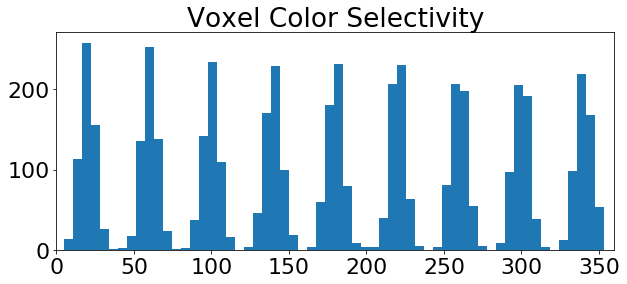

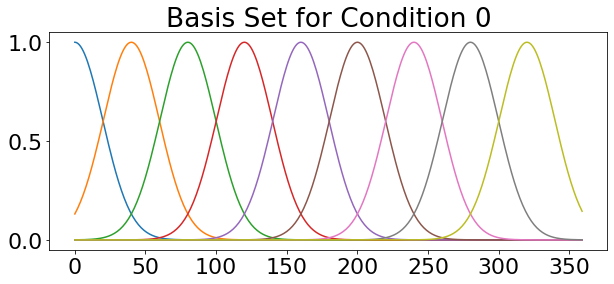

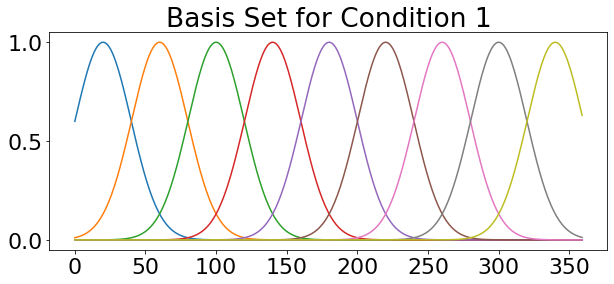

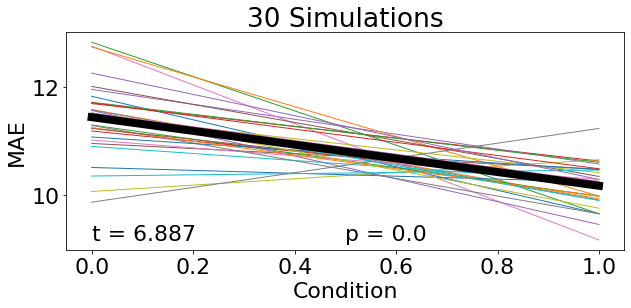

In [90]:
# Simulation parameters:
nsims = 30

ntrials = 252
nvoxels = 50
nneurons = 100

nchannels = 9

gain_diff = 0
noise = 0
vox_sd_mu = 10
vox_sd_sd = 5

# vox_mu = np.array([  0,  40,  80, 120, 160, 200, 240, 280, 320])
# vox_mu = list(map(int,np.linspace(0,360-(360/5),5)))
# vox_mu = np.array([  0,  60,  80, 120, 160, 200, 240, 280, 320])
vox_mu = np.array([  0,  40,  80, 120, 160, 200, 240, 280, 320]) + 20

y_mu = pm.NormalMixture.dist(w=np.ones(9)/9, 
                          mu=vox_mu,
                          sigma=np.ones(9)*vox_sd_sd)
vox_by_neuron_mu = within360(y_mu.random(size=(nvoxels,nneurons)))
plt.hist(vox_by_neuron_mu.flatten(),bins=60)
plt.xlim(xmin=0, xmax = 360)
plt.title('Voxel Color Selectivity')
plt.show()

mae = np.full( (nsims, 2),np.nan )

for sims in np.arange(nsims):
    trial_by_vox, trial_features = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            chan_shift = [0, 0, 0, 0, 0, 0, 0, 0, 0]
            channel_sd = np.ones(nchannels) * 30
        else:
#             chan_shift = [0, 0, 0, 0, 0, 0, 0, 0, 0]
            chan_shift = [20, 20, 20, 20, 20, 20, 20, 20, 20]
            channel_sd = [30, 30, 30, 30, 30, 30, 30, 30, 30]
        mae[sims,cond] = auto_recon(chan_shift,channel_sd)
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('MAE')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [91]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [92]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.5238095238095238
Chance = 0.50


What if we want to decode the actual color?

MAE: 2.1587301587301586


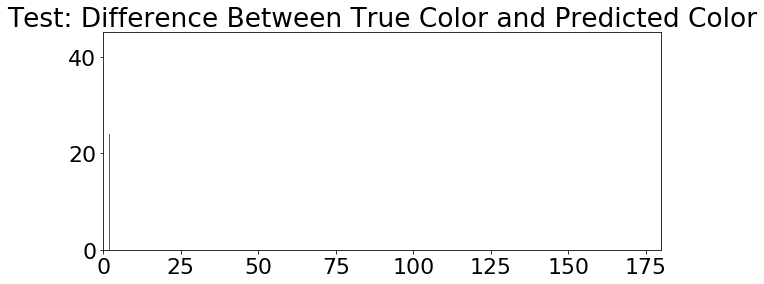

In [95]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(within180(predictions - tstf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = mean_absolute_error(tstf, predictions)
print("MAE: {}".format(tst_mae))

##### 